Calculating tf-idf stats
=============

In [1]:
import json
import matplotlib
import nltk
import operator
import os

from collections import defaultdict
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

%matplotlib inline

/usr/local/lib/python3.5/site-packages/sklearn/utils/fixes.py:64: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if 'order' in inspect.getargspec(np.copy)[0]:


Some basic stuff...
-------------------

Load words from corpus.

In [2]:
article_dir = "../../TextData/CanterburyNewsStoriesCleaned/"

# PlaintextCorpusReader in jupyter vomits on the number of articles we have,
# so do it the old-fashioned way.
raw_articles = {}
for article_fn in os.listdir(article_dir):
    with open(os.path.join(article_dir, article_fn), "r+") as f:
        raw = f.read()
        
    raw_articles[article_fn] = raw

Load vocab...

In [3]:
vocab_fn = "vocab.txt"
with open(vocab_fn, "r+") as f:
    vocab = json.load(f)
vocab_set = {x for v in vocab.values() for x in v} # unpacking this a little...

Load some basic pre-recorded counts (i.e. the tf parts of tf-idf), draw some stuff, and find some interesting files.

In [4]:
counts_per_file_fn = "counts_per_file.txt"
with open(counts_per_file_fn, "r+") as f:
    counts_per_file = json.load(f)

counts_agg_fn = "counts_aggregate.txt"
with open(counts_agg_fn, "r+") as f:
    counts_agg = json.load(f)

sorted_counts = sorted(counts_agg.items(), key=lambda x: -x[1])
sorted_counts[:5]

[('water', 579), ('power', 475), ('road', 374), ('port', 255), ('roads', 199)]

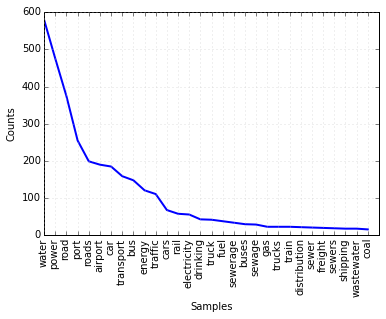

In [5]:
# Plot! Nothing hugely sophisticated - should've probably lemmatized &etc. here
fd = nltk.FreqDist(counts_agg)
fd.plot(30, cumulative=False)

In [6]:
# Most frequent occurrences of the specific word 'water'.
counts_water = {}
for file, vals in counts_per_file.items():
    if 'water' in vals and vals['water'] > 0:
        counts_water[file] = vals['water']

sorted(counts_water.items(), key=lambda x: -x[1])[:5]

[('article-96.cfm_nzh.txt', 22),
 ('article-300.cfm_nzh.txt', 22),
 ('article-112.cfm_nzh.txt', 17),
 ('article-163.cfm_nzh.txt', 16),
 ('Huge-earthquake-rocks-Christchurch_stuff.txt', 15)]

Messing around with tf-idf measurements
-------------------------------------

Use pre-processed text (lemmatized) instead; not sure how much difference it makes?
(lemmatize.py in this directory should do this  - for some reason trying
to do it in jupyter causes issues)

In [7]:
articles = {}
lemmatized_dir = "../../../lemmatized-input/"
for article_fn in os.listdir(lemmatized_dir):
    with open(os.path.join(lemmatized_dir, article_fn), "r+") as f:
        raw = f.read()

    articles[article_fn] = raw

In [8]:
tfidf = TfidfVectorizer(stop_words='english')
tfs = tfidf.fit_transform(articles.values())

feature_names = tfidf.get_feature_names()

Poking around w/inverse document frequency...

In [9]:
idf = tfidf.idf_

sorted_idf_list = sorted(zip(feature_names, idf), key=lambda x: -x[1])
[item for item in sorted_idf_list if item[0] in vocab_set]

[('petroleum', 7.2952660014396464),
 ('potable', 7.2952660014396464),
 ('utilities', 7.2952660014396464),
 ('ports', 6.8898008933314818),
 ('sanitary', 6.8898008933314818),
 ('buses', 6.602118820879701),
 ('commute', 6.602118820879701),
 ('electric', 6.602118820879701),
 ('cars', 6.1966537127715364),
 ('commuter', 5.9089716403197556),
 ('contamination', 5.7911886046633718),
 ('roads', 5.6858280890055459),
 ('sanitation', 5.6858280890055459),
 ('coal', 5.503506532211591),
 ('utility', 5.503506532211591),
 ('plane', 5.349355852384333),
 ('transportation', 5.349355852384333),
 ('fuel', 5.2158244597598102),
 ('wastewater', 5.2158244597598102),
 ('shipping', 5.1551998379433757),
 ('freight', 5.0439742028331507),
 ('ship', 5.0439742028331507),
 ('distribution', 4.9926809084456005),
 ('gas', 4.9926809084456005),
 ('sewer', 4.8529189660704422),
 ('sewage', 4.7695373571313908),
 ('train', 4.7695373571313908),
 ('sewerage', 4.7303166439781101),
 ('drinking', 4.5544259775144447),
 ('rail', 4.5226

Looking at a specific doc (one of the ones from above)...

In [10]:
response = tfidf.transform([articles['article-300.cfm_nzh.txt']])

In [11]:
dense = response.todense()
article = dense.tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(article)), article) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)

pairs = [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores]

# top words for the document
for phrase, score in pairs[:20]:
    print('{0: <20} {1}'.format(phrase, score))

christchurch         0.21352574781345007
say                  0.1776726547411025
tuesday              0.16855824681253329
people               0.1533461449520673
road                 0.1379431753746051
water                0.12889111851143256
welfare              0.12286218748139419
centre               0.12021415657067036
city                 0.10855892498989168
rescue               0.10826346793262967
said                 0.10474989709585704
earthquake           0.09993637387245162
aftershock           0.09927483206427613
supply               0.0974293584909624
service              0.09647665237468082
defence              0.09358455521209726
search               0.09114682947776756
civil                0.0910995903518884
wa                   0.08830300077597815
victim               0.08794343311958258


In [12]:
# looking at our vocab...
for phrase, score in [p for p in pairs if p[0] in vocab_set]:
    print('{0: <20} {1}'.format(phrase, score))

road                 0.1379431753746051
water                0.12889111851143256
power                0.068455161753709
traffic              0.04758665437987463
car                  0.047149997264502974
fuel                 0.04424404311501895
drinking             0.028975220629250835
port                 0.027737557285792837
sewer                0.020582820379120022
energy               0.01568423420015754
bus                  0.015403248836017874
sanitation           0.012057730520618965
distribution         0.0105877982990522
sewage               0.010114585819349663
sewerage             0.010031411867794004
electricity          0.009014398536363441
truck                0.008821477967993246
airport              0.007621589865881538


Something different - dispersion plots

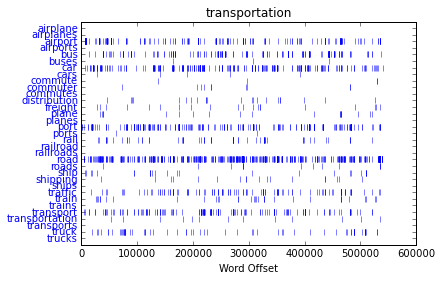

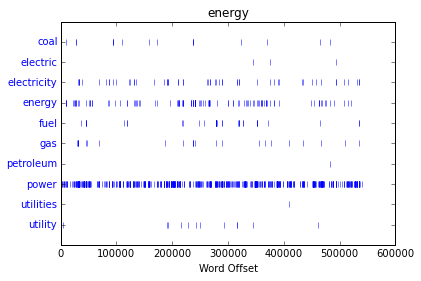

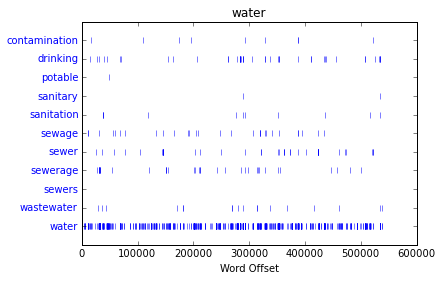

In [13]:
# tok = nltk.tokenize.StanfordTokenizer()
words = []
for ws in articles.values():
    # words.extend(tok.tokenize(ws)) - better but takes forever here
    # this is close enough
    words.extend(ws.split(" "))

for category, subset in vocab.items():
    nltk.draw.dispersion_plot(words, subset, ignore_case=True, title=category)